In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import pandas as pd
import glob
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import tensorboard

In [2]:
object_detection_path = os.path.join('drive', 'MyDrive', 'data', 'object_detection')
semantic_segmentation_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation')

##ROTATING IMAGES

In [39]:
image_path = os.path.join(object_detection_path, 'Baltic_Sea_full_mosaic', 'train', 'modified_labels')

Image padding and rotation

In [40]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_NEAREST, borderValue=(255,255,255))
  return result, rot_mat

def padding(image):
  height = image.shape[0]
  width = image.shape[1]
  max = np.max((height, width)) + 800
  canvas = np.ones((max, max, 3)) * 255
  new_height = int((max - height) / 2)
  new_width = int((max - width) / 2)
  canvas[new_height:height + new_height, new_width: width + new_width,:] = image
  return canvas.astype('uint8')

image = cv2.imread(os.path.join(image_path, '3.tif'))
image_pad = padding(image)
rotated_image, rotation_matrix = rotate_image(image_pad, 85)
saving_path = os.path.join(object_detection_path, 'Baltic_Sea_full_mosaic')

#cv2.imwrite(os.path.join(saving_path, 'train', 'image_rotated.png'), rotated_image)

#TRAINING

##Plot mosaic to check if the rotation angle used is the right one and get bounding boxes coordinates after rotation

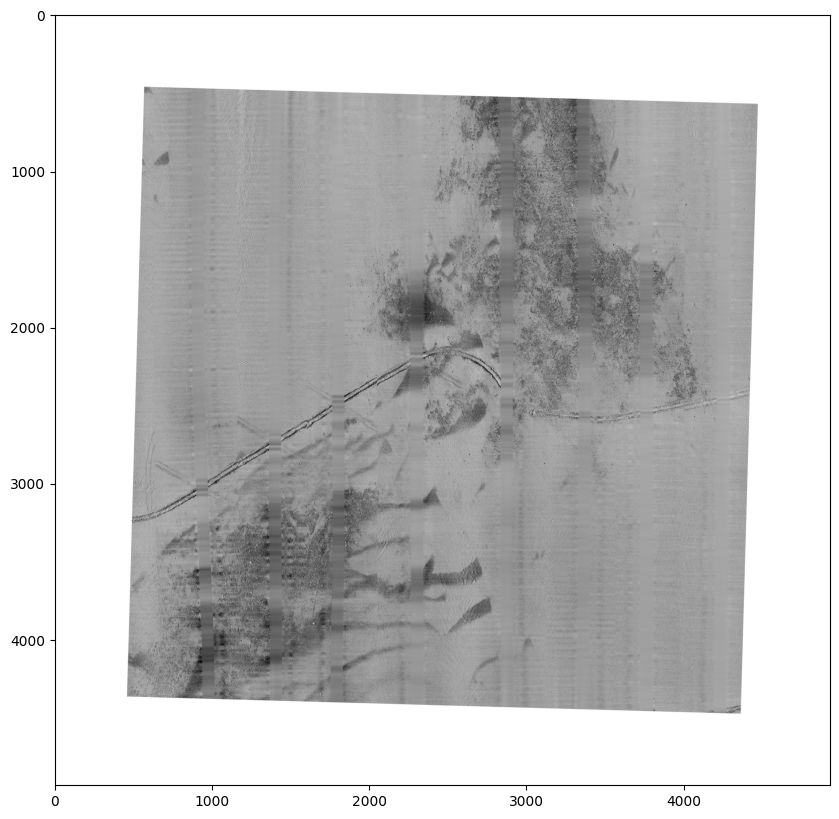

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(rotated_image, aspect='auto')

Boulders bounding boxes coordinates rotation

In [ ]:
def rotate_coordinates(coord, rot_mat):
  x, y = coord[:, 1], coord[:, 2]
  width, height = coord[:, 3], coord[:, 4]
  ones = np.ones((coord.shape[0], 1))

  #bounding box
  p1 = np.array((x - width/2, y + height/2)).T #top left
  p2 = np.array((x + width/2, y + height/2)).T #top right
  p3 = np.array((x - width/2, y - height/2)).T #bottom left
  p4 = np.array((x + width/2, y - height/2)).T #bottom right

  new_labels = np.copy(coord)
  new_labels[:,1:] = 0

  #rotating center coordinate of bounding box
  new_labels[:,1:3] = np.dot(rot_mat, np.array((x, y, ones[:,0]))).T

  #rotating bounding box
  rotated_bounding_box_p1 = np.dot(rot_mat, np.array((p1[:,0], p1[:,1], ones[:,0]))).T
  rotated_bounding_box_p2 = np.dot(rot_mat, np.array((p2[:,0], p2[:,1], ones[:,0]))).T
  rotated_bounding_box_p3 = np.dot(rot_mat, np.array((p3[:,0], p3[:,1], ones[:,0]))).T
  rotated_bounding_box_p4 = np.dot(rot_mat, np.array((p4[:,0], p4[:,1], ones[:,0]))).T

  #getting new width and height for bounding box after rotation
  for i in range(coord.shape[0]):
    x_max = np.max((rotated_bounding_box_p1[i,0], rotated_bounding_box_p2[i,0], rotated_bounding_box_p3[i,0], rotated_bounding_box_p4[i,0]))
    x_min = np.min((rotated_bounding_box_p1[i,0], rotated_bounding_box_p2[i,0], rotated_bounding_box_p3[i,0], rotated_bounding_box_p4[i,0]))
    y_max = np.max((rotated_bounding_box_p1[i,1], rotated_bounding_box_p2[i,1], rotated_bounding_box_p3[i,1], rotated_bounding_box_p4[i,1]))
    y_min = np.min((rotated_bounding_box_p1[i,1], rotated_bounding_box_p2[i,1], rotated_bounding_box_p3[i,1], rotated_bounding_box_p4[i,1]))
    new_labels[i,3:] = np.array((x_max-x_min, y_max-y_min))

  #new_labels[:,3:] = np.dot(rot_mat, np.array((width, height, ones[:,0]))).T

  return new_labels

#boulders_boxes = np.loadtxt(os.path.join(image_path, '1.txt'))
boulders_boxes = np.loadtxt(os.path.join(image_path, '4.txt'))

boulders_boxes[:,1] *= image.shape[1]
boulders_boxes[:,2] *= image.shape[0]
boulders_boxes[:,3] *= image.shape[1]
boulders_boxes[:,4] *= image.shape[0]
boulders_boxes_after_padding = np.copy(boulders_boxes)
boulders_boxes_after_padding[:,1] += int((rotated_image.shape[1] - image.shape[1]) / 2)
boulders_boxes_after_padding[:,2] += int((rotated_image.shape[0] - image.shape[0]) / 2)
boulders_boxes_after_rotation = rotate_coordinates(boulders_boxes_after_padding, rotation_matrix)

##Convert JSON file from LABELME format to YOLO format

In [ ]:
import json

In [ ]:
#Dictionary with the labels of each polygon
segments = {
    "front": 0,
    "shadow": 1
}

file_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation', 'Baltic_Sea', 'boulder_height', 'YOLOv8')
file_list = os.listdir(os.path.join(file_path, 'labels', 'train'))

for file_name in file_list:
  if file_name.endswith('.json'):
    file_number = os.path.splitext(file_name)[0]

    f = open(os.path.join(file_path, 'labels', 'train', file_name))

    data = json.load(f)

    file = open(os.path.join(file_path, 'labels', 'train', file_number + '.txt'), 'w')

    image = cv2.imread(os.path.join(file_path, 'images', 'train', file_number + '.png'))
    shape_y = image.shape[0]
    shape_x = image.shape[1]

    for i in data['shapes']:
      points = np.array(i['points'])
      label = segments[i['label']]
      file.write("%i " %(label))
      for a in range(points.shape[0]):
        normalized_points = np.array(points[a,:])
        normalized_points[0] = normalized_points[0] / shape_x
        normalized_points[1] = normalized_points[1] / shape_y
        #normalized_points = np.array(points[a,1::2] / shape_x)
        file.write("%f %f " %(normalized_points[0], normalized_points[1]))
      file.write("\n")
    file.close()

##Semantic Segmentation for NADIR detection using YOLOV8

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.0/78.2 GB disk)


In [ ]:
from ultralytics import YOLO

In [ ]:
# Load a model
model = YOLO('yolov8n-seg.pt')  # load a pretrained model (recommended for training)

100%|██████████| 6.73M/6.73M [00:00<00:00, 70.2MB/s]


TRAIN THE MODEL

In [ ]:
#os.environ["PYTHONPATH"]="/content/drive/MyDrive/data/semantic_segmentation/YOLOv8"

yaml_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation', 'Baltic_Sea', 'YOLODataset')

# Train the model
model.train(data=os.path.join(yaml_path, 'dataset.yaml'), pretrained=True, epochs=200, imgsz=1280, iou=0.4, visualize=True, project='/content/drive/MyDrive/data/semantic_segmentation/YOLOv8')
#model.train(data=coco128-seg.yaml, epochs=10, imgsz=640)

Ultralytics YOLOv8.0.150 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=drive/MyDrive/data/semantic_segmentation/Baltic_Sea/YOLODataset/dataset.yaml, epochs=200, patience=50, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/data/semantic_segmentation/YOLOv8, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.4, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=True, augment=False, agnostic_nms=False, classes=None,

EVALUATE THE RESULTS IN THE VALIDATION IMAGES

In [ ]:
model.val()

Ultralytics YOLOv8.0.149 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/data/semantic_segmentation/Baltic_Sea/YOLODataset/labels/val.cache... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]
                   all          1          7      0.517      0.767      0.568      0.155      0.895      0.714      0.897      0.331
Speed: 9.6ms preprocess, 2088.6ms inference, 0.0ms loss, 157.4ms postprocess per image
Results saved to runs/segment/val


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee117612470>
fitness: 0.5837176989609736
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)']
maps: array([    0.48572])
names: {0: 'nadir'}
plot: True
results_dict: {'metrics/precision(B)': 0.5168257353486356, 'metrics/recall(B)': 0.7671665968099978, 'metrics/mAP50(B)': 0.5683001443001443, 'metrics/mAP50-95(B)': 0.1550020676088617, 'metrics/precision(M)': 0.8947986244737661, 'metrics/recall(M)': 0.7142857142857143, 'metrics/mAP50(M)': 0.8974242424242422, 'metrics/mAP50-95(M)': 0.33071488826728823, 'fitness': 0.5837176989609736}
save_dir: PosixPath('runs/segment/val')
seg: ultralytics.utils.metrics.Metric object
speed: {'preprocess': 9.55700874328613

PREDICT RESULTS IN NEVER BEFORE SEEN DATA (TEST DATA)

In [ ]:
model = YOLO(os.path.join(semantic_segmentation_path, 'YOLOv8', 'train2', 'weights', 'best.pt'))

In [ ]:
#val_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation', 'Baltic_Sea', 'YOLODataset', 'images', 'train')
#image = cv2.imread(os.path.join(image_path, '1.tif'))
results = model.predict(source=rotated_image, save=True, save_txt=True, iou=0.8, conf=0.2,
                        project='/content/drive/MyDrive/data/semantic_segmentation/YOLOv8', name='image3_iou0.8_conf0.2')


WARNING ⚠️ NMS time limit 0.550s exceeded
0: 1280x1280 45 nadirs, 26.0ms
Speed: 27.9ms preprocess, 26.0ms inference, 2203.2ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to /content/drive/MyDrive/data/semantic_segmentation/YOLOv8/image3_iou0.8_conf0.2
1 label saved to /content/drive/MyDrive/data/semantic_segmentation/YOLOv8/image3_iou0.8_conf0.2/labels


##Getting NADIR coordinates from semantic segmentation and creating tiles

In [ ]:
nadir_labels_path = os.path.join(semantic_segmentation_path, 'YOLOv8')

#image = cv2.imread(os.path.join(nadir_labels_path, 'image7_iou0.8_conf0.42', 'image0.jpg'))
shape = rotated_image.shape[0] #read the image from the predict cell, which doesn't contain the nadir labels

file = open(os.path.join(nadir_labels_path, 'image4_iou0.8_conf0.2/labels/image0.txt'))

nadir_coord = []

for i in file:
    nadir_labels = np.array(i.split(), dtype=float)
    nadir_labels = nadir_labels[1:] * shape
    x_max = np.max(nadir_labels[::2])
    x_min = np.min(nadir_labels[::2])
    x_mean = np.mean((x_max, x_min))
    nadir_coord.append(x_mean)

segments_center = np.sort(np.asarray(nadir_coord))
# In case there are multiple segments that belong to the same Nadir we average the nadir center value
nadir_center = []
i = 0
for id in np.argwhere(np.diff(segments_center) > 50):
  if id == i:
    nadir_center.append(segments_center[int(id)])
    i = int(id) + 1
  else:
    nadir_center.append(np.mean(segments_center[i:int(id)]))
    i = int(id) + 1
nadir_center.append(np.mean((segments_center[i:-1])))

Separate left and right data from Nadir and create tiles

In [ ]:
destiny_folder = os.path.join(object_detection_path, 'tiles_for_train', '40x40', 'Baltic_Sea', 'images', 'val')

def create_tiles(line, tile_size, overlapping, starting_column, text): #the overlapping must be supplied in pixels
  for row in range(0, line.shape[0]-tile_size, tile_size - overlapping): #rows
    for column in range(0, line.shape[1]-tile_size, tile_size - overlapping): #columns
      tile = line[row:row+tile_size, column:column+tile_size, :]
      if text == 'flipped':
        tile = np.flip(tile, axis=1) # flip left data horizontally
      #For training, we need to save the tiles into a folder, later on (when detecting) this lines below can be omitted
      zero_pixels = len(np.nonzero(np.logical_and(tile[:,:,0] == 255, tile[:,:,1] == 255, tile[:,:,2] == 255))[0])
      if zero_pixels < tile_size*tile_size:
        tile_row = 'row_'
        tile_column = 'column_'
        file_name = '%s%i_%s%i_mosaic%i_%s.png' % (tile_row, row, tile_column, column+starting_column, 7, text)
        cv2.imwrite(os.path.join(destiny_folder, file_name), tile)
  return None

In [ ]:
initial = 0
tile_size = 160 #tile size is 160 pixels = 40 m (0.25m resolution), and overlapping 4 pixels = 1 m
for number in range(len(nadir_center)):
  try:
    middle = int(np.mean((nadir_center[number], nadir_center[number+1])))

    left_data = np.copy(rotated_image[:,initial:int(nadir_center[number]),:])
    create_tiles(left_data, tile_size, 4, initial, 'flipped')

    right_data = np.copy(rotated_image[:,int(nadir_center[number]):middle,:])
    create_tiles(right_data, tile_size, 4, int(nadir_center[number]), 'normal')
    initial=middle+1
  except:
    IndexError

##Assigning the boulder labels of each tile

Saving labels of each tile created

In [ ]:
tile_size = 120 #Because the mosaic resolution is 0.25m, so this makes it a 20x20m tile
tile_row = 'row_'
tile_column = 'column_'

tiles_folder = os.path.join(object_detection_path, 'tiles_for_train-mosaic4', '30x30', 'Baltic_Sea', 'images', 'train')
#directory_list = os.listdir(tiles_folder)
tiles_directory_list = glob.glob(os.path.join(tiles_folder,'*.png'))

for tile in tiles_directory_list:
  splitted = os.path.splitext(tile.split("/")[9])[0].split("_")
  row = int(splitted[1])
  column = int(splitted[3])
  if splitted[4] == 'mosaic4':
    for boulder_number in range(boulders_boxes_after_rotation.shape[0]):
      x = boulders_boxes_after_rotation[boulder_number, 1]
      y = boulders_boxes_after_rotation[boulder_number, 2]
      width = boulders_boxes_after_rotation[boulder_number, 3]
      height = boulders_boxes_after_rotation[boulder_number, 4]
      label  = np.ones((1, 5))
      if (x - width/2 >= column) & (x + width/2 <= column + tile_size):
        if (y - height/2 >= row) & (y + height/2 <= row + tile_size):
          if splitted[5] == 'flipped':
            new_x = (tile_size - x + column) / tile_size #Since this tile is flipped, I need to add the tile size to place the bbox in the right position
          else:
            new_x = (x - column) / tile_size # X position within the tile on a 1.0 scale
          new_y = (y - row) / tile_size # Y position within the tile on a 1.0 scale
          new_width = width / tile_size
          new_height = height / tile_size
          label[0,:] = 15, new_x, new_y, new_width, new_height
          tile_labels = pd.DataFrame(data = label)
          try:
            for new_boulder_number in range(boulder_number+1, boulders_boxes_after_rotation.shape[0]):
              x = boulders_boxes_after_rotation[new_boulder_number, 1]
              y = boulders_boxes_after_rotation[new_boulder_number, 2]
              width = boulders_boxes_after_rotation[new_boulder_number, 3]
              height = boulders_boxes_after_rotation[new_boulder_number, 4]
              if (x - width/2 >= column) & (x + width/2 <= column + tile_size):
                if (y - height/2 >= row) & (y + height/2 <= row + tile_size):
                  if splitted[5] == 'flipped':
                    new_x = (tile_size - x + column) / tile_size #This tile is horizontally flipped, we need to add the tile size to place the bbox in the right position
                  else:
                    new_x = (x - column) / tile_size # X position within the tile on a 1.0 scale
                  new_y = (y - row) / tile_size # Y position within the tile on a 1.0 scale
                  new_width = width / tile_size
                  new_height = height / tile_size
                  tile_labels.loc[len(tile_labels.index)] = [15, new_x, new_y, new_width, new_height]
          except:
            IndexError
          label_file_name = '%s.txt' % (os.path.splitext(tile.split("/")[9])[0])
          #label_file_name = '%s%i_%s%i_mosaic1_%s.txt' % (tile_row, row, tile_column, column)
          tile_labels = tile_labels.round(decimals=6)
          tile_labels.to_csv(os.path.join(tiles_folder, label_file_name), header=False, index=False, sep=' ')
          break
        else:
          pass
      else:
        pass

##OBJECT DETECTION TRAINING

##YoloV8

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.210 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.7/78.2 GB disk)


In [ ]:
from ultralytics import YOLO

In [ ]:
# Load a model
model = YOLO('yolov8x.pt')  # load a pretrained model (recommended for training)

100%|██████████| 131M/131M [00:00<00:00, 325MB/s] 


Training the 40x40 the model

In [ ]:
yaml_path = os.path.join(object_detection_path, 'tiles_for_train-mosaic4', '40x40', 'Baltic_Sea')

# Train the model
model.train(data=os.path.join(yaml_path, 'dataset.yaml'), pretrained=True, batch=12, cache=True, save=True, epochs=50, project='/content/drive/MyDrive/data/object_detection/YOLOv8', name='40x40_yolov8x_model_batch12_50epoch_mosaic4_labels_', patience=0)
#model.train(data=coco128-seg.yaml, epochs=10, imgsz=640)

Ultralytics YOLOv8.0.209 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=drive/MyDrive/data/object_detection/tiles_for_train-mosaic4/40x40/Baltic_Sea/dataset.yaml, epochs=50, patience=0, batch=12, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/data/object_detection/YOLOv8, name=40x40_yolov8x_model_batch12_50epoch_mosaic4_labels_, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([15])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7986ae898400>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,

Training the 30x30 model

In [ ]:
yaml_path = os.path.join(object_detection_path, 'tiles_for_train-mosaic4', '30x30', 'Baltic_Sea')

# Train the model
model.train(data=os.path.join(yaml_path, 'dataset.yaml'), pretrained=True, batch=12, cache=True, save=True, epochs=50, project='/content/drive/MyDrive/data/object_detection/YOLOv8', name='30x30_yolov8x_model_batch12_50epoch_mosaic4_labels_', patience=0)
#model.train(data=coco128-seg.yaml, epochs=10, imgsz=640)

Ultralytics YOLOv8.0.210 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=drive/MyDrive/data/object_detection/tiles_for_train-mosaic4/30x30/Baltic_Sea/dataset.yaml, epochs=50, patience=0, batch=12, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/data/object_detection/YOLOv8, name=30x30_yolov8x_model_batch12_50epoch_mosaic4_labels_, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([15])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ec0d987a170>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,

Training the 20x20 model

In [ ]:
yaml_path = os.path.join(object_detection_path, 'tiles_for_train-mosaic4', '20x20', 'Baltic_Sea')

# Train the model
model.train(data=os.path.join(yaml_path, 'dataset.yaml'), pretrained=True, batch=12, cache=True, save=True, epochs=50, project='/content/drive/MyDrive/data/object_detection/YOLOv8', name='20x20_yolov8x_model_batch12_50epoch_mosaic4_labels_', patience=0)
#model.train(data=coco128-seg.yaml, epochs=10, imgsz=640)

Ultralytics YOLOv8.0.210 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=drive/MyDrive/data/object_detection/tiles_for_train-mosaic4/20x20/Baltic_Sea/dataset.yaml, epochs=50, patience=0, batch=12, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/data/object_detection/YOLOv8, name=20x20_yolov8x_model_batch12_50epoch_mosaic4_labels_, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([15])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b19e4413820>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,

Evaluate the model in validation images

In [ ]:
model.val()

Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
100%|██████████| 755k/755k [00:00<00:00, 15.1MB/s]
val: Scanning /content/drive/MyDrive/data/object_detection/tiles_for_train/20x20/Baltic_Sea/labels/val.cache... 252 images, 0 backgrounds, 0 corrupt: 100%|██████████| 252/252 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [24:33<00:00, 92.07s/it]
                   all        252        317      0.779      0.747      0.817       0.36
               boulder        252        317      0.779      0.747      0.817       0.36
Speed: 8.5ms preprocess, 5825.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([15])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b457aa48850>
fitness: 0.4058353980663657
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016])
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'airplane', 4: 'bus', 5: 'train', 6: 'boat', 7: 'traffic light', 8: 'fire hydrant', 9: 'stop sign', 10: 'parking meter', 11: 'bench', 12: 'bird', 13: 'cat', 14: 'dog', 15: 'boulder'}
plot: True
results_dict: {'metrics/precision(B)': 0.7794069284477858, 'metrics/recall(B)': 0.7467739061717806, 'metrics/mAP50(B)': 0.8169480329999228, 'metrics/mAP50-95(B)': 0.36015621640708156, 'fitnes

Predict results in never before seen data (test data)

##SEMANTIC SEGMENTATION FOR MEASURING SHADOW LENGHT

##Training with YOLOV8

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [ ]:
from ultralytics import YOLO

In [ ]:
# Load a model
model = YOLO('yolov8m-seg.pt')  # load a pretrained model (recommended for training)

Train the model

In [ ]:
yaml_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation', 'Baltic_Sea', 'boulder_height', 'YOLOv8')

# Train the model
model.train(data=os.path.join(yaml_path, 'dataset.yaml'), pretrained=True, epochs=200, iou=0.6, visualize=True, save=True, imgsz=64,
            project='/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height',
            name='yolov8m_model_iou06_200epoch_imgsz64_optAdamW)')

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=drive/MyDrive/data/semantic_segmentation/Baltic_Sea/boulder_height/YOLOv8/dataset.yaml, epochs=200, patience=50, batch=16, imgsz=32, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height, name=yolov8m_model_iou06_200epoch_imgsz32_optAdamW), exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.6, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1,

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff560618ee0>
fitness: 0.00610592569564498
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)']
maps: array([  0.0067143,   0.0019418])
names: {0: 'front', 1: 'shadow'}
plot: True
results_dict: {'metrics/precision(B)': 0.00625, 'metrics/recall(B)': 0.4, 'metrics/mAP50(B)': 0.011406465786473875, 'metrics/mAP50-95(B)': 0.0018852639117196486, 'metrics/precision(M)': 0.005625, 'metrics/recall(M)': 0.36, 'metrics/mAP50(M)': 0.010700255386410815, 'metrics/mAP50-95(M)': 0.0024427956197875856, 'fitness': 0.00610592569564498}
save_dir: PosixPath('/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height/yolov8m_model_iou06_200epoch_imgsz32_opt

Evaluate the results in the validation images

In [ ]:
model.val()

Ultralytics YOLOv8.0.178 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8l-seg summary (fused): 295 layers, 45913430 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/data/semantic_segmentation/Baltic_Sea/boulder_height/YOLOv8/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]
                   all         50        100      0.519      0.557      0.478      0.138      0.487      0.498       0.37     0.0914
                 front         50         50      0.581      0.554       0.46       0.12      0.498      0.437      0.307     0.0701
                shadow         50         50      0.457       0.56      0.496      0.157      0.476       0.56      0.432      0.113
Speed: 6.8ms preprocess, 51.8ms inference, 0.0ms loss, 3.9ms post

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fb653692020>
fitness: 0.29148133458699693
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)']
maps: array([    0.18973,     0.26974])
names: {0: 'front', 1: 'shadow'}
plot: True
results_dict: {'metrics/precision(B)': 0.5188752713848904, 'metrics/recall(B)': 0.5572492982634885, 'metrics/mAP50(B)': 0.477666132371383, 'metrics/mAP50-95(B)': 0.13831996642490235, 'metrics/precision(M)': 0.48691309144072553, 'metrics/recall(M)': 0.49845198744639563, 'metrics/mAP50(M)': 0.3695670212808452, 'metrics/mAP50-95(M)': 0.09141116604373554, 'fitness': 0.29148133458699693}
save_dir: PosixPath('/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_heig

Predict results in never before seen data (test data)

In [ ]:
model = YOLO(os.path.join(semantic_segmentation_path, 'YOLOv8', 'boulder_height', 'train2', 'weights', 'best.pt'))

In [ ]:
#val_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation', 'Baltic_Sea', 'YOLODataset', 'images', 'train')
#image = cv2.imread(os.path.join(image_path, '1.tif'))
results = model.predict(source=rotated_image, save=True, save_txt=True, iou=0.8, conf=0.2,
                        project='/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height', name='image7_iou0.8_conf0.2')

#DETECTION

##OBJECT DETECTION

In [5]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.211 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


In [6]:
from ultralytics import YOLO

**STEP 1:** Load pre-trained object detection models

In [7]:
model_20x20 = YOLO(os.path.join(object_detection_path, 'YOLOv8', '20x20_yolov8x_model_batch12_50epoch_mosaic4_labels_', 'weights', 'best.pt'))
model_30x30 = YOLO(os.path.join(object_detection_path, 'YOLOv8', '30x30_yolov8x_model_batch12_50epoch_mosaic4_labels_', 'weights', 'best.pt'))
model_40x40 = YOLO(os.path.join(object_detection_path, 'YOLOv8', '40x40_yolov8x_model_batch12_50epoch_mosaic4_labels_', 'weights', 'best.pt'))

**STEP 2:** Get the Nadir coordinates from the semantic segmentation step

In [8]:
nadir_labels_path = os.path.join(semantic_segmentation_path, 'YOLOv8')

shape = rotated_image.shape[0] #read the image from the predict cell, which doesn't contain the nadir labels

file = open(os.path.join(nadir_labels_path, 'image3_iou0.8_conf0.2/labels/image0.txt'))

nadir_coord = []

for i in file:
    nadir_labels = np.array(i.split(), dtype=float)
    nadir_labels = nadir_labels[1:] * shape
    x_max = np.max(nadir_labels[::2])
    x_min = np.min(nadir_labels[::2])
    x_mean = np.mean((x_max, x_min))
    nadir_coord.append(x_mean)

segments_center = np.sort(np.asarray(nadir_coord))
# In case there are multiple segments that belong to the same Nadir we average the nadir center value
nadir_center = []
i = 0
for id in np.argwhere(np.diff(segments_center) > 50):
  if id == i:
    nadir_center.append(segments_center[int(id)])
    i = int(id) + 1
  else:
    nadir_center.append(np.mean(segments_center[i:int(id)]))
    i = int(id) + 1
nadir_center.append(np.mean((segments_center[i:-1])))

**STEP 3:** Create functions to get tiles and detect boulders

Function to detect boulders

In [9]:
def detect(tile, tile_size, y, x, orientation):
  if tile_size == 80:
    prediction = model_20x20(tile, iou=0.5, conf=0.3)
  if tile_size == 120:
    prediction = model_30x30(tile, iou=0.5, conf=0.3)
  if tile_size == 160:
    prediction = model_40x40(tile, iou=0.5, conf=0.3)
  for results in prediction:
    boxes = results.boxes.xyxyn.cpu().numpy()*tile_size
    if orientation == 'flipped':
      boxes[:,0::2] = tile_size - boxes[:,0::2]
    boxes[:,0::2] += x
    boxes[:,1::2] += y
  return boxes

Function to create the tiles

In [10]:
def create_tiles(line, tile_size, overlapping, starting_column, text): #the overlapping must be supplied in pixels
  bbox = np.empty(0, dtype='float32')
  for row in range(0, line.shape[0]-tile_size, tile_size - overlapping): #rows
    for column in range(0, line.shape[1]-tile_size, tile_size - overlapping): #columns
      tile = line[row:row+tile_size, column:column+tile_size, :]
      if text == 'flipped':
        tile = np.flip(tile, axis=1) # flip left data horizontally
      zero_pixels = len(np.nonzero(np.logical_and(tile[:,:,0] == 255, tile[:,:,1] == 255, tile[:,:,2] == 255))[0]) #This assumes colormap is greyscale
      if zero_pixels < tile_size*tile_size*0.3:
        detections = detect(tile, tile_size, row, column+starting_column, text)
        if detections.size > 0:
          #bbox.append(detections.flatten())
          bbox = np.append(bbox, detections.flatten())
        else:
          pass
  return bbox #np.asarray(bbox)

Function to fill bounding boxes with white pixels

In [11]:
def white_pixels(array, mask, orientation): #fill rectangles with white pixels
  array = array.flatten()
  if orientation == 'flipped':
    xmin = array[2::4].astype('int32')
    xmax = array[::4].astype('int32')
  else:
    xmin = array[::4].astype('int32')
    xmax = array[2::4].astype('int32')
  ymin = array[1::4].astype('int32')
  ymax = array[3::4].astype('int32')
  for i in range(xmin.size):
    mask[ymin[i]:ymax[i], xmin[i]:xmax[i]] = 1
  return mask

Predefined values for shadow detection

In [ ]:
''' Dictionary with the classes names '''
segments = {
    "front": 0,
    "shadow": 1
}

avg_altitude = 15
resolution = 0.25 #m

column_names = ['TargetName', 'CaptureDateTimeUTC', 'FishHeight', 'DistanceToTarget', 'AcousticFile', 'MapProjection', 'ConfidenceLevel', 'BoulderHeight', 'BoulderShadow', 'BoulderLenght', 'BoulderWidth']
boulder_information = pd.DataFrame(columns=column_names)

In [ ]:
detect_shadow_model_n = YOLO(os.path.join(semantic_segmentation_path, 'YOLOv8', 'boulder_height', 'yolov8n_model_iou06_200epoch_2', 'weights', 'best.pt'))
detect_shadow_model_m = YOLO(os.path.join(semantic_segmentation_path, 'YOLOv8', 'boulder_height', 'yolov8m_model_iou06_200epoch_imgsz50)', 'weights', 'best.pt'))

Function for measuring boulder height

In [ ]:
def measure_boulder_height(image, counter, box, orientation, no_boxes, combined_boxes, start_x, start_y):
  results = detect_shadow_model_m.predict(source=image, save=False, save_txt=False, iou=0.2, conf=0.4, show_labels=False, boxes=False)

  counter_float = f'{counter:04}'
  name = 'contact' + counter_float

  utc_time = datetime.utcnow()
  filename = '1.tif' #later on should take the one supplied by the user
  map_projection = '-' #-------------------------EDIT

  for r in results:
    result_classes = r.boxes.data[:,5].cpu().numpy() # It can also be done using r.boxes.cls (?)

    altitude = avg_altitude + round(float(np.random.uniform(low=-3.0,high=3.0, size=1)), 2)
    #measuring boulder shadow and height
    distances, boulder_heights, shadows = [], [], []
    shadow_indexes = np.argwhere(result_classes == segments["shadow"])
    for number_shadows in range(len(shadow_indexes)):
      masks = r.masks.xy[shadow_indexes[number_shadows,0]]
      if masks.size > 0 :
        max_length_y_coord = np.argmax(masks[:,0]) # Y coordinate of where the length of acoustic shadow is max

        indexes = np.where((masks[:,1] >= (masks[max_length_y_coord,1] - 3.5)) & (masks[:,1] <= (masks[max_length_y_coord,1] + 3.5)))

        x_min = np.min(masks[indexes,0])
        x_max = np.max(masks[:,0])
        shadow_length = x_max - x_min
        if shadow_length < 1:
          shadow_length = 1
        shadow = (shadow_length) * resolution #length of boulder shadow

        if orientation == 'left':
          x_min_distance = x_min + box[no_boxes*4 + 2]
        else:
          x_min_distance = x_min + box[no_boxes*4]

        distance = abs(nadir_center[number] - x_min_distance) * resolution

        boulder_height = shadow * altitude / (distance + shadow)

        distances.append(distance)
        boulder_heights.append(boulder_height)
        shadows.append(shadow)

    #getting confidence level
    middle_x = int(start_x + image.shape[1]/2)
    middle_y = int(start_y + image.shape[0]/2)
    if combined_boxes[middle_y, middle_x, 0] == 1:
      confidence_level = 1
    if combined_boxes[middle_y, middle_x, 0] == 2:
      confidence_level = 2
    if combined_boxes[middle_y, middle_x, 0] == 3:
      confidence_level = 3

    #measuring boulder length and width
    boulder_lengths, boulder_widths, x_min_distances = [], [], []
    boulder_indexes = np.argwhere(result_classes == segments["front"])
    for number_boulders in range(len(boulder_indexes)):
      masks = r.masks.xy[boulder_indexes[number_boulders,0]]

      if masks.size > 0:
        boulder_length = (np.max(masks[:,1]) - np.min(masks[:,1])) * resolution

        boulder_width = (np.max(masks[:,0]) - np.min(masks[:,0])) * resolution

        boulder_lengths.append(boulder_length)
        boulder_widths.append(boulder_width)

        if orientation == 'left':
          x_min_distances.append(np.min(masks[:,0]) + box[no_boxes*4 + 2])
        else:
          x_min_distances.append(np.min(masks[:,0]) + box[no_boxes*4])

  if len(shadow_indexes) != 0 and len(boulder_indexes) != 0:
    boulder_distance = np.nanmean(distance)
    height = np.nanmean(boulder_heights)
    boulder_shadow = np.nanmean(shadows)
    length = np.nanmean(boulder_lengths)
    width = np.nanmean(boulder_widths)

  else:
    if len(shadow_indexes) == 0:
      boulder_shadow = '-'
      height = '-'
      boulder_distance = '-'
    if len(shadow_indexes) > 0:
      boulder_distance = np.nanmean(distance)
      height = np.nanmean(boulder_heights)
      boulder_shadow = np.nanmean(shadows)
    if len(boulder_indexes) == 0:
      length = '-'
      width = '-'
    if len(boulder_indexes) > 0:
      length = np.nanmean(boulder_lengths)
      width = np.nanmean(boulder_widths)
      x_min_distance = np.nanmean(x_min_distances)
      boulder_distance = abs(nadir_center[number] - x_min_distance) * resolution

  return name, utc_time, filename, map_projection, altitude, boulder_shadow, height, boulder_distance, length, width, confidence_level

**STEP 4:** Do the detection

In [12]:
initial = 0
final = rotated_image.shape[1]
overlap = 4 #Overlapping between tiles = 1 meter (0.25m resolution)
tile_20x20 = 80 #tile size is 80 pixels = 20 m
tile_30x30 = 120 #30 meters
tile_40x40 = 160 #40 meters
mask = np.copy(rotated_image).astype('int32')
mask[:] = 0
mask_20x20 = np.copy(mask)
mask_30x30 = np.copy(mask)
mask_40x40 = np.copy(mask)
counter = 0

left_boxes_20x20 = []
left_boxes_30x30 = []
left_boxes_40x40 = []

right_boxes_20x20 = []
right_boxes_30x30 = []
right_boxes_40x40 = []

for number in range(len(nadir_center)):
  try:
    middle = int(np.mean((nadir_center[number], nadir_center[number+1])))
    left_data = np.copy(rotated_image[:,initial:int(nadir_center[number]),:])
    right_data = np.copy(rotated_image[:,int(nadir_center[number]):middle,:])

  except IndexError:
    left_data = np.copy(rotated_image[:,initial:int(nadir_center[number]),:])
    right_data = np.copy(rotated_image[:,int(nadir_center[number]):final,:])

  #------------------------20x20 TILES------------------------
  boxes_20x20_left = create_tiles(left_data, tile_20x20, overlap, initial, 'flipped')
  boxes_20x20_right = create_tiles(right_data, tile_20x20, overlap, int(nadir_center[number]), 'normal')

  mask_20x20 = white_pixels(boxes_20x20_left, mask_20x20, 'flipped')
  mask_20x20 = white_pixels(boxes_20x20_right, mask_20x20, 'normal')

  #------------------------30x30 TILES------------------------
  boxes_30x30_left = create_tiles(left_data, tile_30x30, overlap, initial, 'flipped')
  boxes_30x30_right = create_tiles(right_data, tile_30x30, overlap, int(nadir_center[number]), 'normal')

  mask_30x30 = white_pixels(boxes_30x30_left, mask_30x30, 'flipped')
  mask_30x30 = white_pixels(boxes_30x30_right, mask_30x30, 'normal')

  #------------------------40x40 TILES------------------------
  boxes_40x40_left = create_tiles(left_data, tile_40x40, overlap, initial, 'flipped')
  boxes_40x40_right = create_tiles(right_data, tile_40x40, overlap, int(nadir_center[number]), 'normal')

  mask_40x40 = white_pixels(boxes_40x40_left, mask_40x40, 'flipped')
  mask_40x40 = white_pixels(boxes_40x40_right, mask_40x40, 'normal')

  mask_3combined = mask_20x20 + mask_30x30 + mask_40x40

  left_boxes_20x20 = np.append(left_boxes_20x20, boxes_20x20_left)
  left_boxes_30x30 = np.append(left_boxes_30x30, boxes_30x30_left)
  left_boxes_40x40 = np.append(left_boxes_40x40, boxes_40x40_left)

  right_boxes_20x20 = np.append(right_boxes_20x20, boxes_20x20_right)
  right_boxes_30x30 = np.append(right_boxes_30x30, boxes_30x30_right)
  right_boxes_40x40 = np.append(right_boxes_40x40, boxes_40x40_right)

  for no_boxes in range(int(boxes_20x20_left.size/4)):
    boulder_image = np.flip(rotated_image[int(boxes_20x20_left[no_boxes*4+1]):int(boxes_20x20_left[no_boxes*4+3]), int(boxes_20x20_left[no_boxes*4+2]):int(boxes_20x20_left[no_boxes*4])], axis=1)

    name, utc_time, filename, MapProjection, altitude, boulder_shadow, height, boulder_distance, length, width, confidence = measure_boulder_height(boulder_image, counter, boxes_20x20_left,
                                                                                                                                                    'left', no_boxes, mask_3combined, boxes_20x20_left[no_boxes*4+2],
                                                                                                                                                    boxes_20x20_left[no_boxes*4+1])

    boulder_information.loc[len(boulder_information.index)] = [name, utc_time, altitude, boulder_distance,
                                                                filename, MapProjection, confidence, height,
                                                                boulder_shadow, length, width]
    counter += 1

  for no_boxes in range(int(boxes_20x20_right.size/4)):
    boulder_image = rotated_image[int(boxes_20x20_right[no_boxes*4+1]):int(boxes_20x20_right[no_boxes*4+3]), int(boxes_20x20_right[no_boxes*4]):int(boxes_20x20_right[no_boxes*4+2])]

    name, utc_time, filename, MapProjection, altitude, boulder_shadow, height, boulder_distance, length, width, confidence = measure_boulder_height(boulder_image, counter, boxes_20x20_right,
                                                                                                                                                    'right', no_boxes, mask_3combined, boxes_20x20_right[no_boxes*4],
                                                                                                                                                    boxes_20x20_right[no_boxes*4+1])

    boulder_information.loc[len(boulder_information.index)] = [name, utc_time, altitude, boulder_distance,
                                                                filename, MapProjection, confidence, height,
                                                                boulder_shadow, length, width]
    counter += 1
  initial=middle+1

Streaming output truncated to the last 5000 lines.
0: 640x640 (no detections), 59.4ms
Speed: 2.4ms preprocess, 59.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 boulders, 61.0ms
Speed: 2.5ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 58.9ms
Speed: 2.7ms preprocess, 58.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 boulder, 60.9ms
Speed: 2.4ms preprocess, 60.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 boulders, 60.3ms
Speed: 2.5ms preprocess, 60.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 59.0ms
Speed: 2.6ms preprocess, 59.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 boulders, 60.8ms
Speed: 2.6ms preprocess, 60.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 boulders, 60.3ms
Speed: 2.

In [ ]:
boulder_information

TargetName         CaptureDateTimeUTC  FishHeight DistanceToTarget  \
0    contact0000 2023-10-07 15:00:11.440201       13.50        47.947126   
1    contact0001 2023-10-07 15:00:11.467688       12.21       113.024275   
2    contact0002 2023-10-07 15:00:11.496682       17.79        95.932417   
3    contact0003 2023-10-07 15:00:11.525820       16.42         65.21739   
4    contact0004 2023-10-07 15:00:11.554335       15.56        94.642271   
..           ...                        ...         ...              ...   
611  contact0611 2023-10-07 15:00:30.213541       15.44        65.312609   
612  contact0612 2023-10-07 15:00:30.244068       17.42        32.558367   
613  contact0613 2023-10-07 15:00:30.277497       13.12        40.824236   
614  contact0614 2023-10-07 15:00:30.309026       17.98                -   
615  contact0615 2023-10-07 15:00:30.335630       12.47        95.139116   

    AcousticFile MapProjection  ConfidenceLevel BoulderHeight BoulderShadow  \
0          1.tif             -                1      0.346141      1.261719   
1          1.tif             -                3       0.18617          1.75   
2          1.tif             -                1      0.154993      0.863281   
3          1.tif             -                1      0.311638      1.261719   
4          1.tif             -                2      0.171489      1.054688   
..           ...           ...              ...           ...           ...   
611        1.tif             -                1             -             -   
612        1.tif             -                2       0.29719      0.589844   
613        1.tif             -                1      0.348286      1.113281   
614        1.tif             -                1             -             -   
615        1.tif             -                1      0.069245       0.53125   

    BoulderLenght BoulderWidth  
0        0.664062     0.664062  
1           3.625        0.875  
2        1.195312     0.464844  
3        2.003906     0.519531  
4        2.847656     0.421875  
..            ...          ...  
611      1.527344      0.53125  
612      0.996094     0.265625  
613             -            -  
614             -            -  
615             -            -  

[616 rows x 11 columns]

[     910.91      615.91      890.93      642.48]


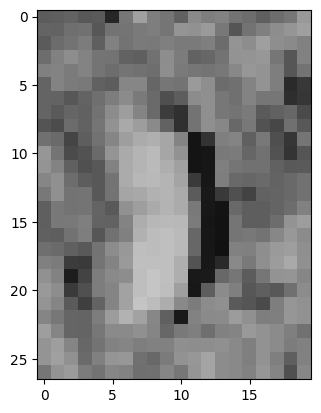

In [ ]:
a = 4
boulder_image = np.flip(rotated_image[int(boxes_20x20_left[a*4+1]):int(boxes_20x20_left[a*4+3]), int(boxes_20x20_left[a*4+2]):int(boxes_20x20_left[a*4])], axis=1)
print(boxes_20x20_left[16:20])
plt.imshow(boulder_image)

In [ ]:
results = detect_shadow_model_m.predict(source=boulder_image, save=False, save_txt=False, iou=0.2, conf=0.4, show_labels=False, boxes=False)
for r in results:
    result_classes = r.boxes.data[:,5].cpu().numpy() # It can also be done using r.boxes.cls (?)

    #altitude = avg_altitude + round(float(np.random.uniform(low=-3.0,high=3.0, size=1)), 2)
    #measuring boulder shadow and height
    distances, boulder_heights, shadows = [], [], []
    shadow_indexes = np.argwhere(result_classes == segments["shadow"])
    for number_shadows in range(len(shadow_indexes)):
      masks = r.masks.xy[shadow_indexes[number_shadows,0]]

      if masks.size > 0 :
        max_length_y_coord = np.argmax(masks[:,0]) # Y coordinate of where the length of acoustic shadow is max

        indexes = np.where((masks[:,1] >= (masks[max_length_y_coord,1] - 3.5)) & (masks[:,1] <= (masks[max_length_y_coord,1] + 3.5)))

        x_min = np.min(masks[indexes,0])
        x_max = np.max(masks[:,0])

        shadow_length = x_max - x_min
        if shadow_length < 1:
          shadow_length = 1
        shadow = (shadow_length) * resolution #length of boulder shadow

        x_min_distance = x_min + boxes_20x20_left[a*4 + 2]

        distance = abs(nadir_center[0] - x_min_distance) * resolution


0: 64x64 1 front, 1 shadow, 34.1ms
Speed: 0.8ms preprocess, 34.1ms inference, 3.6ms postprocess per image at shape (1, 3, 64, 64)


**STEP 4:** Combine the 3 mask and transform matrix to RGB

In [ ]:
mask_3combined = mask_20x20 + mask_30x30 + mask_40x40

In [ ]:
mask_3combined[np.nonzero(mask_3combined[:,:,0] == 0)] = [255, 255, 255]
mask_3combined[np.nonzero(mask_3combined[:,:,0] == 1)] = [255, 0, 0]
mask_3combined[np.nonzero(mask_3combined[:,:,0] == 2)] = [0, 0, 255]
mask_3combined[np.nonzero(mask_3combined[:,:,0] == 3)] = [0, 255, 0]
mask_3combined = mask_3combined.astype('uint8')

##MEASURING BOULDER'S HEIGHT

Load previously trained model

In [ ]:
detect_shadow_model_n = YOLO(os.path.join(semantic_segmentation_path, 'YOLOv8', 'boulder_height', 'yolov8n_model_iou06_200epoch_2', 'weights', 'best.pt'))
detect_shadow_model_m = YOLO(os.path.join(semantic_segmentation_path, 'YOLOv8', 'boulder_height', 'yolov8m_model_iou06_200epoch_imgsz50)', 'weights', 'best.pt'))

Predict shadow of boulder

In [ ]:
boulder_image = rotated_image[int(boxes_20x20_left[9]):int(boxes_20x20_left[11]), int(boxes_20x20_left[10]):int(boxes_20x20_left[8])]
boulder_image = np.flip(boulder_image, axis=1)
results = detect_shadow_model_m.predict(source=boulder_image, save=False, save_txt=False, iou=0.2, conf=0.4, show_labels=False, boxes=False,
                                      project='/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height/prediction',
                                      name='yolov8_image1_boulder_iou0.2_conf0.4_')


0: 64x64 1 front, 1 shadow, 14.2ms
Speed: 0.8ms preprocess, 14.2ms inference, 6.9ms postprocess per image at shape (1, 3, 64, 64)


Get mask coordinates for each class and use those coordinates to measure shadow lenght





In [ ]:
''' Dictionary with the classes names '''
segments = {
    "front": 0,
    "shadow": 1
}

avg_altitude = 15
resolution = 0.25 #m

In [ ]:
for r in results:
    result_classes = r.boxes.data[:,5].cpu().numpy() # It can also be done using r.boxes.cls (?)
    shadow_indexes = np.argwhere(result_classes == segments["shadow"])
    for number_shadows in range(len(shadow_indexes)):
      masks = r.masks.xyn[shadow_indexes[number_shadows,0]]
      max_length_y_coord = np.argmax(masks[:,0]) # Y coordinate of where the length of acoustic shadow is max

      indexes = np.where((masks[:,1] >= (masks[max_length_y_coord,1] - 0.1)) & (masks[:,1] <= (masks[max_length_y_coord,1] + 0.1)))

      x_min = np.min(masks[indexes,0])
      x_max = np.max(masks[:,0])

      shadow = (x_max - x_min) * boulder_image.shape[1] * resolution #length of boulder shadow

      x_min_distance = x_min + boxes_20x20_left[10]

      altitude = avg_altitude + round(float(np.random.uniform(low=-3.0,high=3.0, size=1)), 2)

      distance = abs(nadir_center[np.searchsorted(nadir_center, x_min_distance, side='left')] - x_min_distance) * resolution

      boulder_height = shadow * altitude / (distance + shadow)

      #the x_min distance only include the distance within the tile, not from the tile to the nadir, this needs to be fixed
    boulder_indexes = np.argwhere(result_classes == segments["front"])
    if len(boulder_indexes) > 0:
      for number_boulders in range(len(boulder_indexes)):
        masks = r.masks.xyn[boulder_indexes[number_boulders,0]]

        boulder_length = (np.max(masks[:,1]) - np.min(masks[:,1])) * boulder_image.shape[1] * resolution

        boulder_width = (np.max(masks[:,0]) - np.min(masks[:,0])) * boulder_image.shape[1] * resolution

In [ ]:
column_names = ['TargetName', 'CaptureDateTimeUTC', 'FishHeight', 'DistanceToTarget', 'AcousticFile', 'MapProjection', 'BoulderHeight', 'BoulderShadow', 'BoulderLenght', 'BoulderWidth']
boulder_information = pd.DataFrame(columns=column_names)

name = 'aaa' #-------------------------EDIT
utc_time = datetime.utcnow()
filename = '1.tif' #later on should take the one supplied by the user
MapProjection = '-' #-------------------------EDIT

if len(shadow_indexes) == 0:
  shadow = '-'
  boulder_height = '-'
if len(boulder_indexes) == 0:
  boulder_length = '-'
  boulder_width = '-'
boulder_information.loc[len(boulder_information.index)] = [name, utc_time, altitude, distance, filename, MapProjection, boulder_height, shadow, boulder_length, boulder_width]

In [ ]:
boulder_information

TargetName         CaptureDateTimeUTC  FishHeight  DistanceToTarget  \
0        aaa 2023-10-02 18:45:04.709518       14.43         35.377681   

  AcousticFile MapProjection  BoulderHeight  BoulderShadow  BoulderLenght  \
0        1.tif             -       0.317873       0.796875          1.375   

   BoulderWidth  
0      0.332031

In [ ]:
boulder_information.to_csv(os.path.join(object_detection_path, 'contacts_generated.txt'), index=False) #Later on should be user defined path

# Using models in test data

Load pre-saved bbox

In [ ]:
left_boxes_20x20 = np.loadtxt(os.path.join(object_detection_path, 'tiles_for_test', 'mosaic4', 'left_boxes_20x20_mosaic4.txt'))
right_boxes_20x20 = np.loadtxt(os.path.join(object_detection_path, 'tiles_for_test', 'mosaic4', 'right_boxes_20x20_mosaic4.txt'))

left_boxes_30x30 = np.loadtxt(os.path.join(object_detection_path, 'tiles_for_test', 'mosaic4', 'left_boxes_30x30_mosaic4.txt'))
right_boxes_30x30 = np.loadtxt(os.path.join(object_detection_path, 'tiles_for_test', 'mosaic4', 'right_boxes_30x30_mosaic4.txt'))

left_boxes_40x40 = np.loadtxt(os.path.join(object_detection_path, 'tiles_for_test', 'mosaic4', 'left_boxes_40x40_mosaic4.txt'))
right_boxes_40x40 = np.loadtxt(os.path.join(object_detection_path, 'tiles_for_test', 'mosaic4', 'right_boxes_40x40_mosaic4.txt'))

In [ ]:
#true_values = np.loadtxt(os.path.join(object_detection_path, 'Baltic_Sea_full_mosaic', 'train', '4.txt'))

Rotate True bbox

In [13]:
def rotate_coordinates(coord, rot_mat):
  x, y = coord[:, 1], coord[:, 2]
  width, height = coord[:, 3], coord[:, 4]
  ones = np.ones((coord.shape[0], 1))

  #bounding box
  p1 = np.array((x - width/2, y + height/2)).T #top left
  p2 = np.array((x + width/2, y + height/2)).T #top right
  p3 = np.array((x - width/2, y - height/2)).T #bottom left
  p4 = np.array((x + width/2, y - height/2)).T #bottom right

  new_labels = np.copy(coord)
  new_labels[:,1:] = 0

  #rotating center coordinate of bounding box
  new_labels[:,1:3] = np.dot(rot_mat, np.array((x, y, ones[:,0]))).T

  #rotating bounding box
  rotated_bounding_box_p1 = np.dot(rot_mat, np.array((p1[:,0], p1[:,1], ones[:,0]))).T
  rotated_bounding_box_p2 = np.dot(rot_mat, np.array((p2[:,0], p2[:,1], ones[:,0]))).T
  rotated_bounding_box_p3 = np.dot(rot_mat, np.array((p3[:,0], p3[:,1], ones[:,0]))).T
  rotated_bounding_box_p4 = np.dot(rot_mat, np.array((p4[:,0], p4[:,1], ones[:,0]))).T

  #getting new width and height for bounding box after rotation
  for i in range(coord.shape[0]):
    x_max = np.max((rotated_bounding_box_p1[i,0], rotated_bounding_box_p2[i,0], rotated_bounding_box_p3[i,0], rotated_bounding_box_p4[i,0]))
    x_min = np.min((rotated_bounding_box_p1[i,0], rotated_bounding_box_p2[i,0], rotated_bounding_box_p3[i,0], rotated_bounding_box_p4[i,0]))
    y_max = np.max((rotated_bounding_box_p1[i,1], rotated_bounding_box_p2[i,1], rotated_bounding_box_p3[i,1], rotated_bounding_box_p4[i,1]))
    y_min = np.min((rotated_bounding_box_p1[i,1], rotated_bounding_box_p2[i,1], rotated_bounding_box_p3[i,1], rotated_bounding_box_p4[i,1]))
    new_labels[i,3:] = np.array((x_max-x_min, y_max-y_min))

  #new_labels[:,3:] = np.dot(rot_mat, np.array((width, height, ones[:,0]))).T

  return new_labels

boulders_boxes = np.loadtxt(os.path.join(image_path, '3.txt'))

boulders_boxes[:,1] *= image.shape[1]
boulders_boxes[:,2] *= image.shape[0]
boulders_boxes[:,3] *= image.shape[1]
boulders_boxes[:,4] *= image.shape[0]
boulders_boxes_after_padding = np.copy(boulders_boxes)
boulders_boxes_after_padding[:,1] += int((rotated_image.shape[1] - image.shape[1]) / 2)
boulders_boxes_after_padding[:,2] += int((rotated_image.shape[0] - image.shape[0]) / 2)
boulders_boxes_after_rotation = rotate_coordinates(boulders_boxes_after_padding, rotation_matrix)

Plot image with bounding boxes

40x40

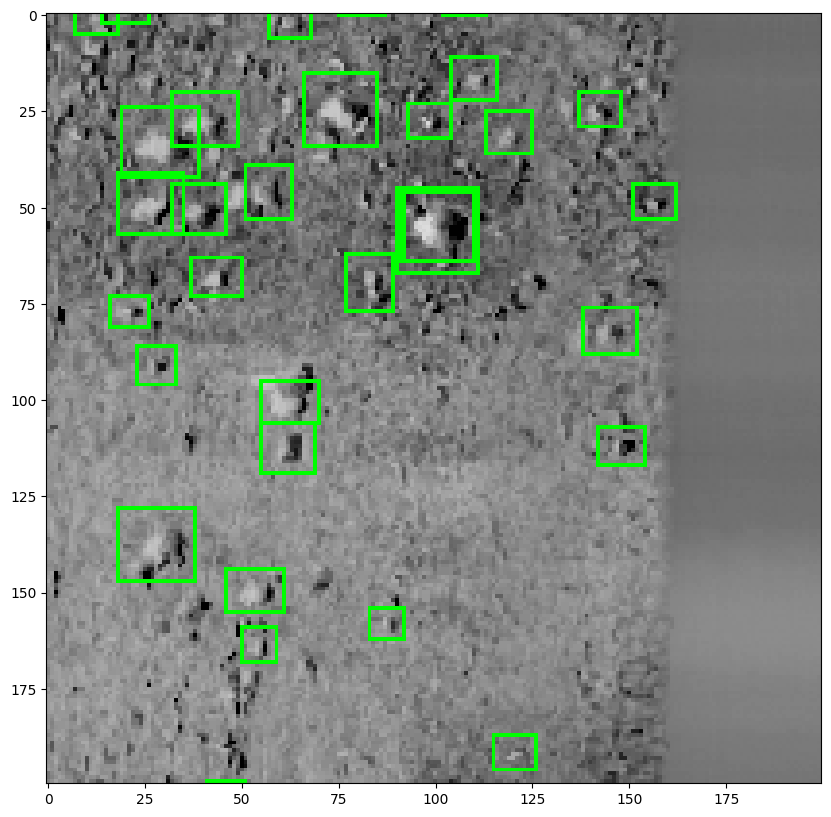

In [ ]:
for i in range(left_boxes_40x40.shape[0]//4):
    x = int(left_boxes_40x40[i*4 + 2])
    y = int(left_boxes_40x40[i*4 + 3])
    x_2 = int(left_boxes_40x40[i*4])
    y_2 = int(left_boxes_40x40[i*4 + 1])
    image_bbox = cv2.rectangle(rotated_image, (x, y), (x_2, y_2), (0, 255, 0), 1)

for i in range(right_boxes_40x40.shape[0]//4):
    x = int(right_boxes_40x40[i*4])
    y = int(right_boxes_40x40[i*4 + 3])
    x_2 = int(right_boxes_40x40[i*4+2])
    y_2 = int(right_boxes_40x40[i*4 + 1])
    image_bbox = cv2.rectangle(rotated_image, (x, y), (x_2, y_2), (0, 255, 0), 1)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(image_bbox[3600:3800, 1600:1800], aspect='auto')

30x30

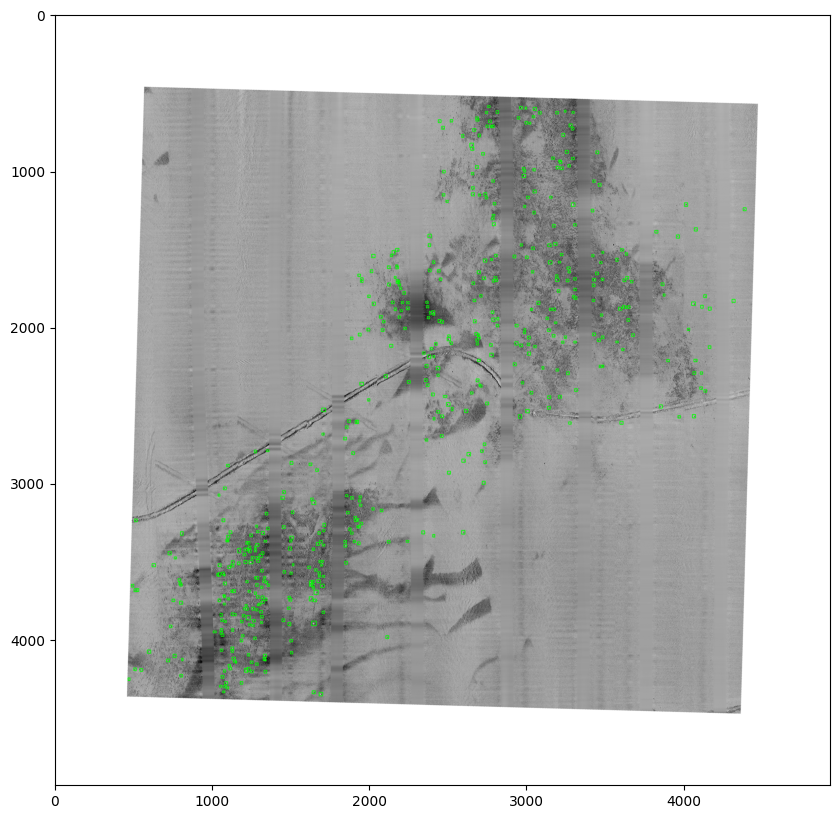

In [ ]:
for i in range(left_boxes_30x30.shape[0]//4):
    x = int(left_boxes_30x30[i*4 + 2])
    y = int(left_boxes_30x30[i*4 + 3])
    x_2 = int(left_boxes_30x30[i*4])
    y_2 = int(left_boxes_30x30[i*4 + 1])
    image_bbox = cv2.rectangle(rotated_image, (x, y), (x_2, y_2), (0, 255, 0), 4)

for i in range(right_boxes_30x30.shape[0]//4):
    x = int(right_boxes_30x30[i*4])
    y = int(right_boxes_30x30[i*4 + 3])
    x_2 = int(right_boxes_30x30[i*4+2])
    y_2 = int(right_boxes_30x30[i*4 + 1])
    image_bbox = cv2.rectangle(rotated_image, (x, y), (x_2, y_2), (0, 255, 0), 4)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(image_bbox, aspect='auto')

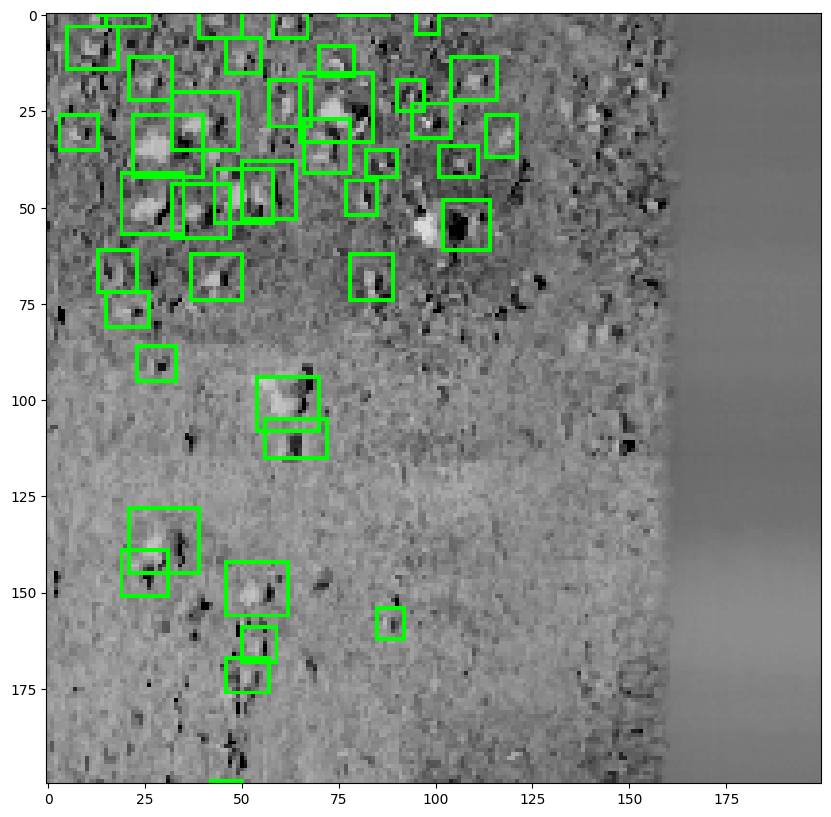

In [19]:
for i in range(left_boxes_30x30.shape[0]//4):
    x = int(left_boxes_30x30[i*4 + 2])
    y = int(left_boxes_30x30[i*4 + 3])
    x_2 = int(left_boxes_30x30[i*4])
    y_2 = int(left_boxes_30x30[i*4 + 1])
    image_bbox = cv2.rectangle(rotated_image, (x, y), (x_2, y_2), (0, 255, 0), 1)

for i in range(right_boxes_30x30.shape[0]//4):
    x = int(right_boxes_30x30[i*4])
    y = int(right_boxes_30x30[i*4 + 3])
    x_2 = int(right_boxes_30x30[i*4+2])
    y_2 = int(right_boxes_30x30[i*4 + 1])
    image_bbox = cv2.rectangle(rotated_image, (x, y), (x_2, y_2), (0, 255, 0), 1)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(image_bbox[3600:3800, 1600:1800], aspect='auto')

20x20

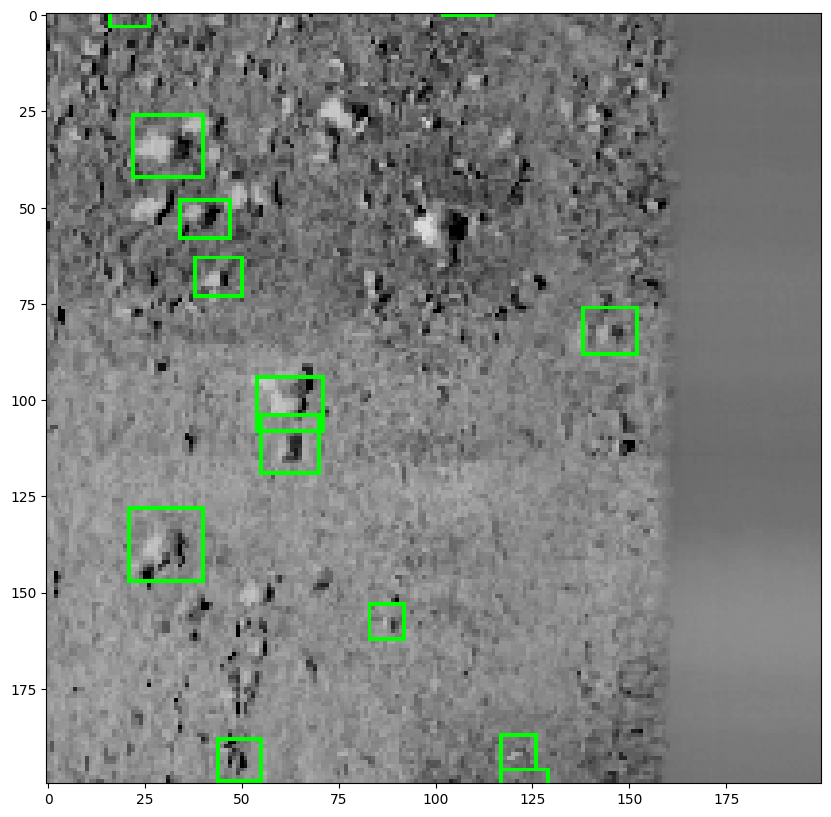

In [ ]:
for i in range(left_boxes_20x20.shape[0]//4):
    x = int(left_boxes_20x20[i*4 + 2])
    y = int(left_boxes_20x20[i*4 + 3])
    x_2 = int(left_boxes_20x20[i*4])
    y_2 = int(left_boxes_20x20[i*4 + 1])
    image_bbox = cv2.rectangle(rotated_image, (x, y), (x_2, y_2), (0, 255, 0), 1)

for i in range(right_boxes_20x20.shape[0]//4):
    x = int(right_boxes_20x20[i*4])
    y = int(right_boxes_20x20[i*4 + 3])
    x_2 = int(right_boxes_20x20[i*4+2])
    y_2 = int(right_boxes_20x20[i*4 + 1])
    image_bbox = cv2.rectangle(rotated_image, (x, y), (x_2, y_2), (0, 255, 0), 1)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(image_bbox[3600:3800, 1600:1800], aspect='auto')

True data

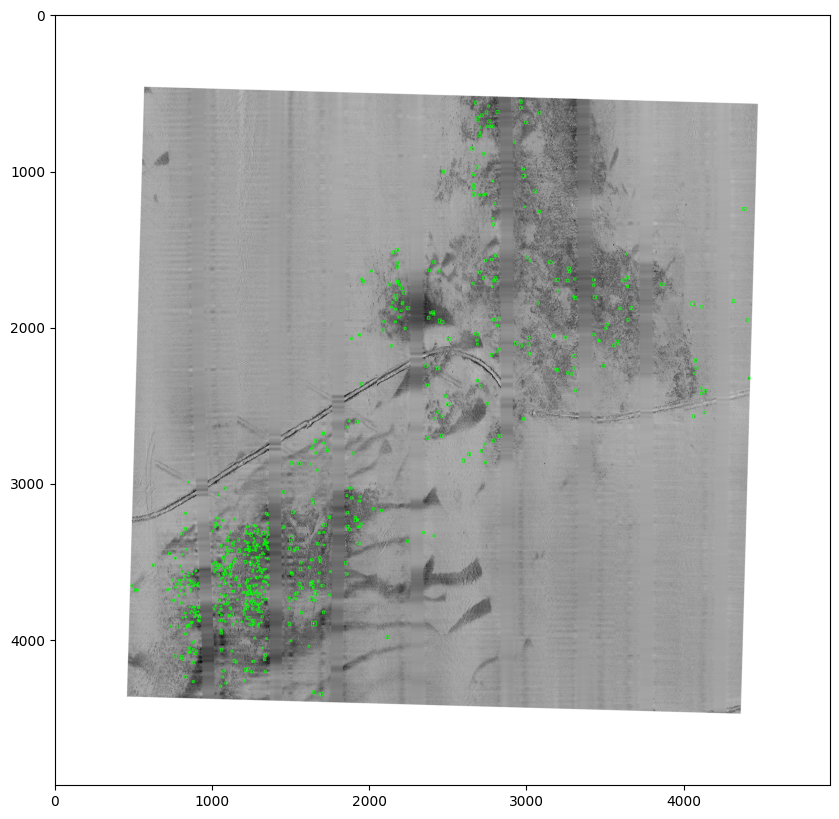

In [ ]:
for i in range(boulders_boxes_after_rotation.shape[0]):
    x = int(boulders_boxes_after_rotation[i, 1])
    y = int(boulders_boxes_after_rotation[i, 2])
    w = int(boulders_boxes_after_rotation[i, 3])
    h = int(boulders_boxes_after_rotation[i, 4])
    image_bbox = cv2.rectangle(rotated_image, (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), (0, 255, 0), 4)
    #print("x,y,w,h:",x,y,w,h)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(image_bbox, aspect='auto')

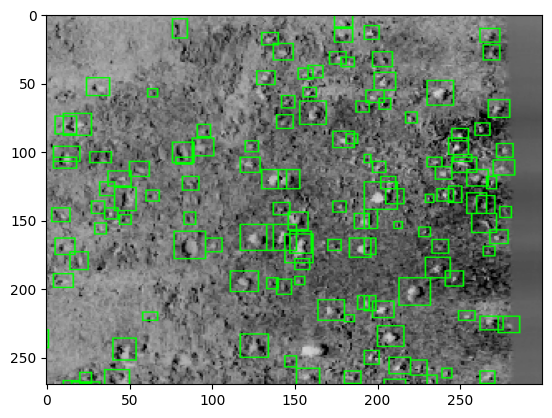

In [21]:
#fig, ax = plt.subplots(figsize=(10,10))
#ax = plt.imshow(image_bbox[3260:3530, 1085:1385], aspect='auto')
plt.imshow(image_bbox[3260:3530, 1085:1385], aspect='auto')

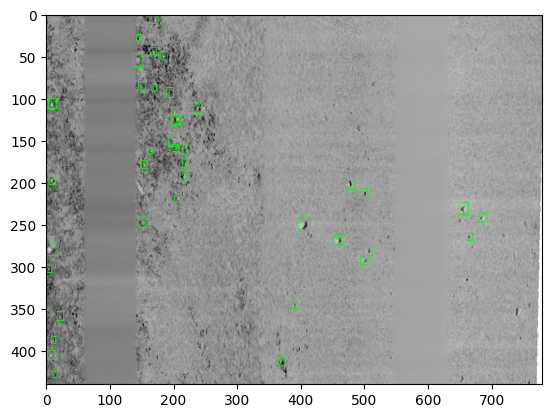

In [20]:
plt.imshow(image_bbox[1600:2040, 3660:4440], aspect='auto')

In [ ]:
cv2.imwrite(os.path.join(saving_path, 'image3_objects_detected_TRUE.png'), rotated_image)

True

Rotate image and bounding boxes back to original coordinates

In [14]:
def de_padding(original, padded):
  height = original.shape[0]
  width = original.shape[1]
  max = np.max(padded.shape)
  prev_height = int((max - height) / 2)
  prev_width = int((max - width) / 2)
  canvas = padded[prev_height:height+prev_height, prev_width:width+prev_width]
  return canvas.astype('uint8')

des_rotated_image, des_rotation_matrix = rotate_image(rotated_image, -85)
des_padded_image = de_padding(image, des_rotated_image)

Get the center coordinate of the bounding boxes from the different models

In [15]:
coordinates_20x20 = np.zeros((1,5))
coordinates_30x30 = np.zeros((1,5))
coordinates_40x40 = np.zeros((1,5))

#---------------20x20 boxes---------------
for i in range(left_boxes_20x20.shape[0]//4):
    x = int(left_boxes_20x20[i*4 + 2])
    y = int(left_boxes_20x20[i*4 + 3])
    x_2 = int(left_boxes_20x20[i*4])
    y_2 = int(left_boxes_20x20[i*4 + 1])
    width = abs(x - x_2)
    height = abs(y - y_2)
    x_center = np.min((x, x_2)) + width
    y_center = np.min((y, y_2)) + height
    coordinates_20x20 = np.vstack([coordinates_20x20, [15, x_center, y_center, width, height]]) #15 is the label number assigned for boulders

for i in range(right_boxes_20x20.shape[0]//4):
    x = int(right_boxes_20x20[i*4])
    y = int(right_boxes_20x20[i*4 + 3])
    x_2 = int(right_boxes_20x20[i*4+2])
    y_2 = int(right_boxes_20x20[i*4 + 1])
    width = abs(x - x_2)
    height = abs(y - y_2)
    x_center = np.min((x, x_2)) + width
    y_center = np.min((y, y_2)) + height
    coordinates_20x20 = np.vstack([coordinates_20x20, [15, x_center, y_center, width, height]])

#---------------30x30 boxes---------------
for i in range(left_boxes_30x30.shape[0]//4):
    x = int(left_boxes_30x30[i*4 + 2])
    y = int(left_boxes_30x30[i*4 + 3])
    x_2 = int(left_boxes_30x30[i*4])
    y_2 = int(left_boxes_30x30[i*4 + 1])
    width = abs(x - x_2)
    height = abs(y - y_2)
    x_center = np.min((x, x_2)) + width
    y_center = np.min((y, y_2)) + height
    coordinates_30x30 = np.vstack([coordinates_30x30, [15, x_center, y_center, width, height]])

for i in range(right_boxes_30x30.shape[0]//4):
    x = int(right_boxes_30x30[i*4])
    y = int(right_boxes_30x30[i*4 + 3])
    x_2 = int(right_boxes_30x30[i*4+2])
    y_2 = int(right_boxes_30x30[i*4 + 1])
    width = abs(x - x_2)
    height = abs(y - y_2)
    x_center = np.min((x, x_2)) + width
    y_center = np.min((y, y_2)) + height
    coordinates_30x30 = np.vstack([coordinates_30x30, [15, x_center, y_center, width, height]])

#---------------40x40 boxes---------------
for i in range(left_boxes_40x40.shape[0]//4):
    x = int(left_boxes_40x40[i*4 + 2])
    y = int(left_boxes_40x40[i*4 + 3])
    x_2 = int(left_boxes_40x40[i*4])
    y_2 = int(left_boxes_40x40[i*4 + 1])
    width = abs(x - x_2)
    height = abs(y - y_2)
    x_center = np.min((x, x_2)) + width
    y_center = np.min((y, y_2)) + height
    coordinates_40x40 = np.vstack([coordinates_40x40, [15, x_center, y_center, width, height]])

for i in range(right_boxes_40x40.shape[0]//4):
    x = int(right_boxes_40x40[i*4])
    y = int(right_boxes_40x40[i*4 + 3])
    x_2 = int(right_boxes_40x40[i*4+2])
    y_2 = int(right_boxes_40x40[i*4 + 1])
    width = abs(x - x_2)
    height = abs(y - y_2)
    x_center = np.min((x, x_2)) + width
    y_center = np.min((y, y_2)) + height
    coordinates_40x40 = np.vstack([coordinates_40x40, [15, x_center, y_center, width, height]])

Rotate bounding boxes and locate them in the original image

In [17]:
boulders_boxes_original_image_20x20 = rotate_coordinates(coordinates_20x20, des_rotation_matrix)
boulders_boxes_original_image_30x30 = rotate_coordinates(coordinates_30x30, des_rotation_matrix)
boulders_boxes_original_image_40x40 = rotate_coordinates(coordinates_40x40, des_rotation_matrix)

In [18]:
boulders_boxes_original_image_20x20[:,1] -= int((rotated_image.shape[1] - image.shape[1]) / 2)
boulders_boxes_original_image_20x20[:,2] -= int((rotated_image.shape[0] - image.shape[0]) / 2)

boulders_boxes_original_image_30x30[:,1] -= int((rotated_image.shape[1] - image.shape[1]) / 2)
boulders_boxes_original_image_30x30[:,2] -= int((rotated_image.shape[0] - image.shape[0]) / 2)

boulders_boxes_original_image_40x40[:,1] -= int((rotated_image.shape[1] - image.shape[1]) / 2)
boulders_boxes_original_image_40x40[:,2] -= int((rotated_image.shape[0] - image.shape[0]) / 2)

# Create tiles for density grids



In [19]:
size = 50 #Tile size in meters
resolution = 0.25 #Pixel resolution in meters

tile_size = int(size / resolution)

In [41]:
def create_density_grid(image, tile_size):
  grid = np.ones_like(image)*255
  for row in range(0, image.shape[0]-tile_size, tile_size): #rows
    for column in range(0, image.shape[1]-tile_size, tile_size): #columns
      tile_counter = 0
      for boulder_number in range(boulders_boxes_original_image_20x20.shape[0]):
            x = boulders_boxes_original_image_20x20[boulder_number, 1]
            y = boulders_boxes_original_image_20x20[boulder_number, 2]
            label  = np.ones((1, 5))
            if (x >= column) & (x <= column + tile_size):
              if (y >= row) & (y <= row + tile_size):
                tile_counter += 1
            else:
              pass
      if (tile_counter >= 1) & (tile_counter <= 5):
        #grid[row:row+tile_size, column:column+tile_size, 0] *= 255
        grid[row:row+tile_size, column:column+tile_size, 1:] -= 127
      if tile_counter > 5:
        #grid[row:row+tile_size, column:column+tile_size, 0] *= 255
        grid[row:row+tile_size, column:column+tile_size, 1:] *= 0
      else:
        #grid[row:row+tile_size, column:column+tile_size, :] *= 255
        pass
  return grid

density_grid = create_density_grid(des_padded_image, tile_size)

20x20

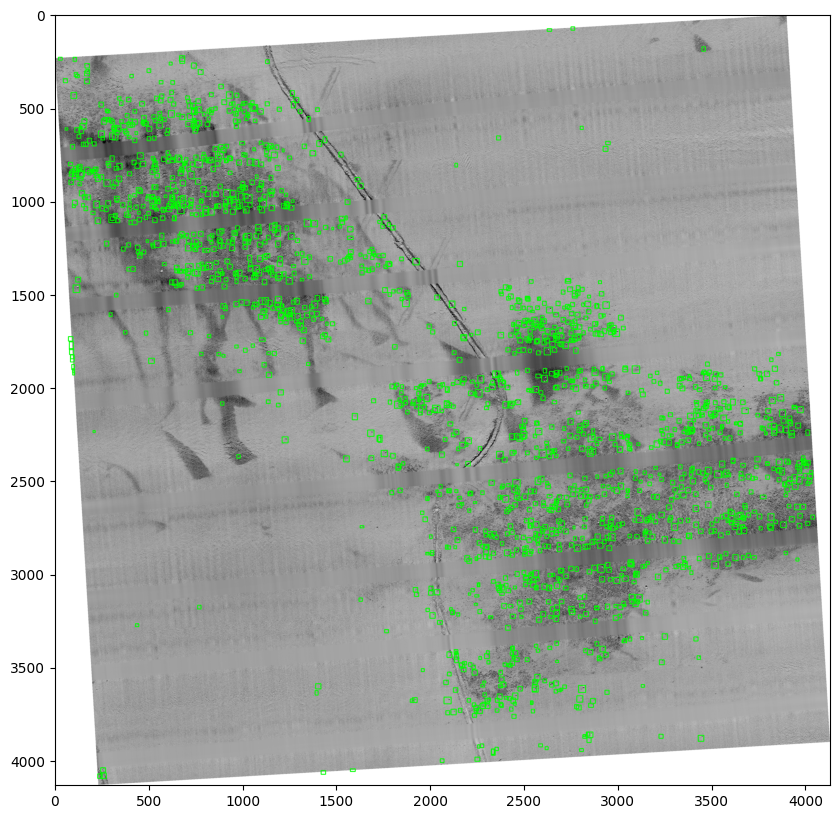

In [43]:
for i in range(boulders_boxes_original_image_20x20.shape[0]):
    x = int(boulders_boxes_original_image_20x20[i,1])
    y = int(boulders_boxes_original_image_20x20[i,2])
    width = int(boulders_boxes_original_image_20x20[i,3])
    height = int(boulders_boxes_original_image_20x20[i,4])
    image_bbox = cv2.rectangle(image, (x-width, y+height), (x+width, y-height), (0, 255, 0), 4)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(image_bbox, aspect='auto')

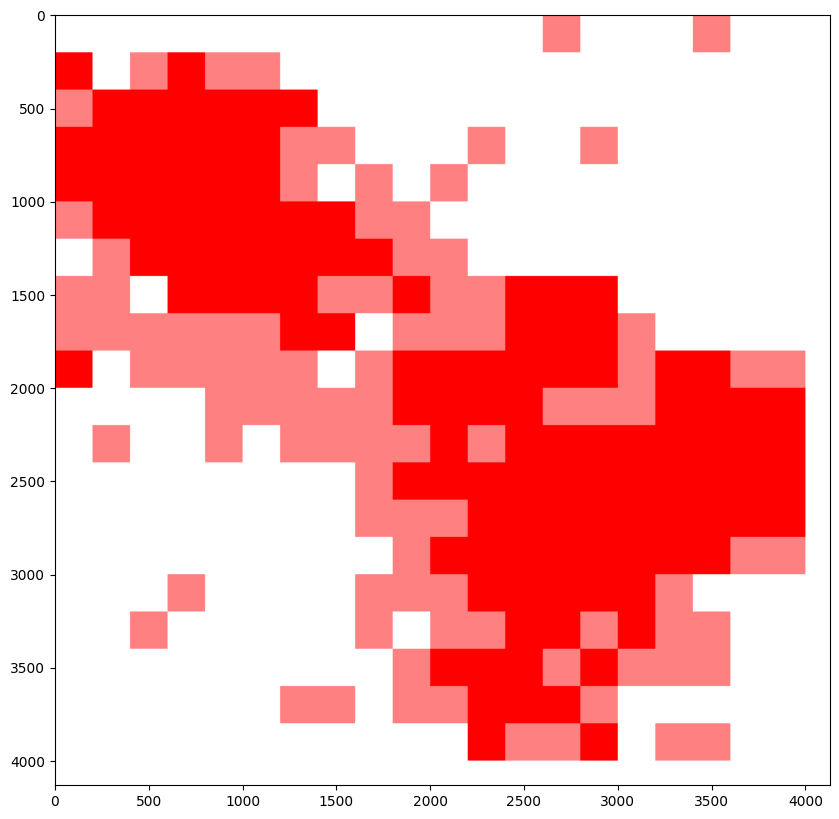

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(density_grid, aspect='auto')

30x30

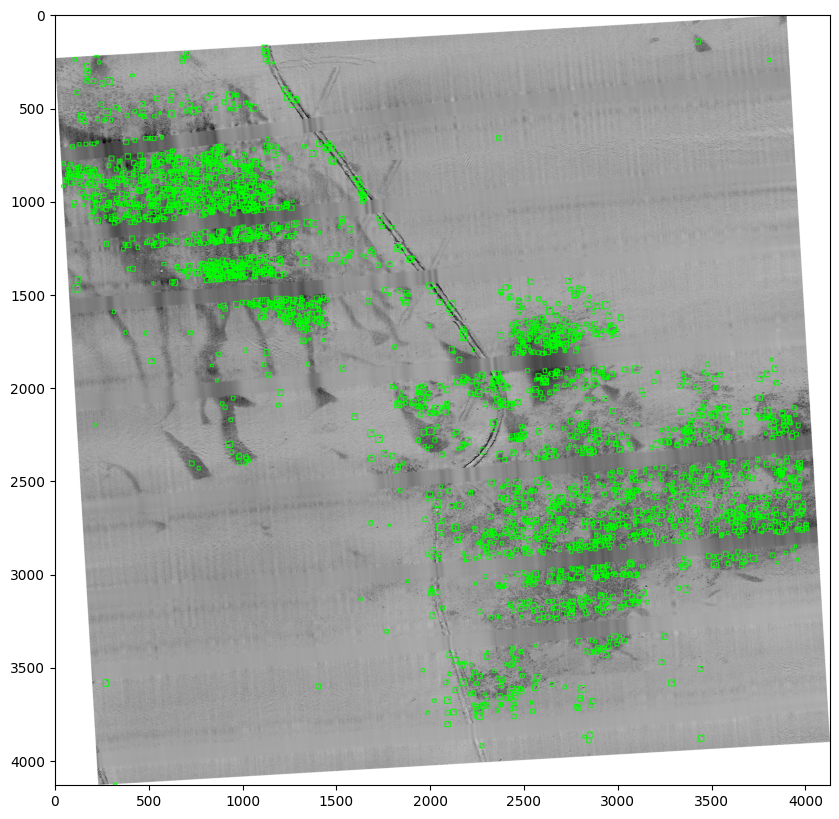

In [38]:
for i in range(boulders_boxes_original_image_30x30.shape[0]):
    x = int(boulders_boxes_original_image_30x30[i,1])
    y = int(boulders_boxes_original_image_30x30[i,2])
    width = int(boulders_boxes_original_image_30x30[i,3])
    height = int(boulders_boxes_original_image_30x30[i,4])
    image_bbox = cv2.rectangle(image, (x-width, y+height), (x+width, y-height), (0, 255, 0), 4)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(image_bbox, aspect='auto')

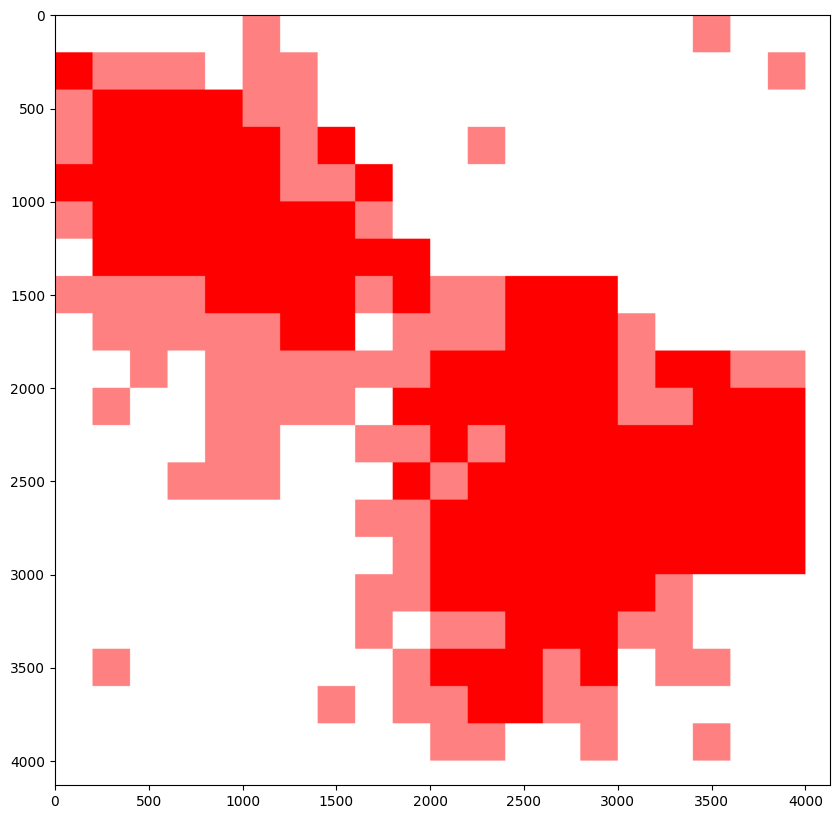

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(density_grid, aspect='auto')

40x40

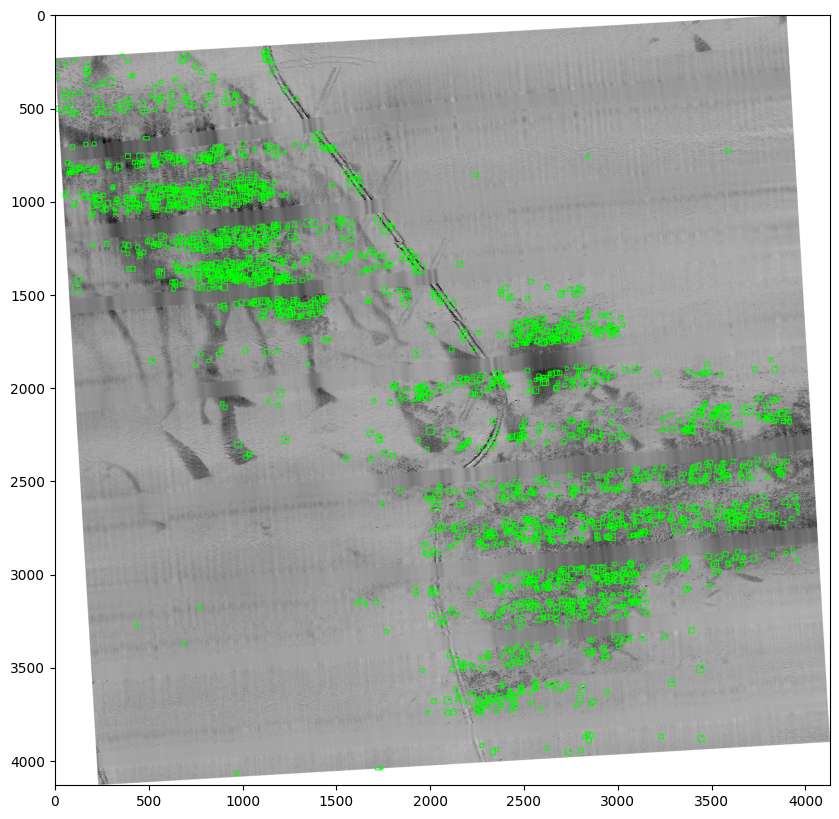

In [30]:
for i in range(boulders_boxes_original_image_40x40.shape[0]):
    x = int(boulders_boxes_original_image_40x40[i,1])
    y = int(boulders_boxes_original_image_40x40[i,2])
    width = int(boulders_boxes_original_image_40x40[i,3])
    height = int(boulders_boxes_original_image_40x40[i,4])
    image_bbox = cv2.rectangle(image, (x-width, y+height), (x+width, y-height), (0, 255, 0), 4)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(image_bbox, aspect='auto')

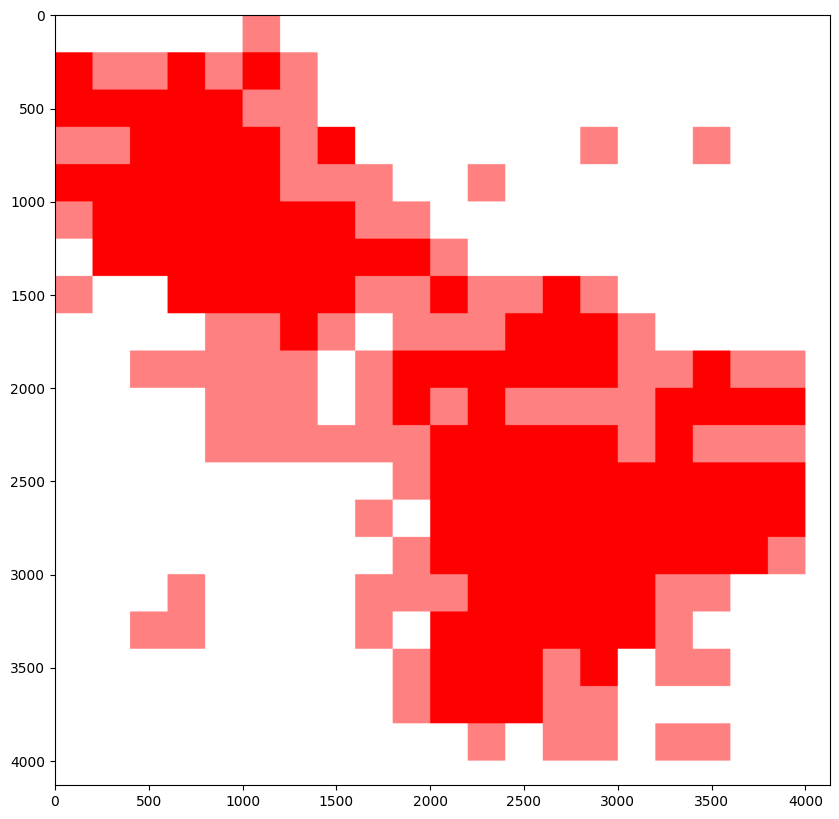

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(density_grid, aspect='auto')